In [1]:
import numpy as np
import pandas as pd
import datetime
import re
from dateutil.parser import parse
import glob
import sys
import openpyxl as opx
import xlrd
import seaborn as sns
import random
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib import font_manager, rc
matplotlib.rcParams['axes.unicode_minus'] = False
font_path = "C:/Windows/Fonts/malgun.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

# KPEC Time-series chart 로딩

In [2]:
df1 = pd.read_csv('./data/220302/220302 time_series_chart.csv', parse_dates = True)

In [3]:
df1['DateTime']= pd.to_datetime(df1['DateTime'])

In [4]:
df1=df1[(df1['DateTime']<'2022-03-01 00:00:00')]

In [5]:
df1

,DateTime,energyTotalProduce,energyTotalConsume,ToESS(We),ESSout(We),energyTotalSelfConsumeRate,energyTotalSelfRate,SCF,LCF,SCF_acc,LCF_acc
2004,2022-02-28 23:59:00,354,24377,0.867,0.0,1.0,0.694843,1.0,0.014486,0.55383,0.384030
2005,2022-02-28 23:58:00,354,24773,0.717,0.0,1.0,0.694848,1.0,0.014261,0.55383,0.384033
2006,2022-02-28 23:57:00,353,24766,0.500,0.0,1.0,0.694853,1.0,0.014233,0.55383,0.384035
2007,2022-02-28 23:56:00,354,25836,0.833,0.0,1.0,0.694857,1.0,0.013670,0.55383,0.384038
2008,2022-02-28 23:55:00,353,25193,0.583,0.0,1.0,0.694862,1.0,0.013989,0.55383,0.384040
...,...,...,...,...,...,...,...,...,...,...,...
227734,2021-09-13 00:17:00,10,7728,0.000,0.0,1.0,0.001555,1.0,0.001294,1.00000,0.001555
227735,2021-09-13 00:15:00,10,8105,0.000,0.0,1.0,0.001573,1.0,0.001234,1.00000,0.001573
227736,2021-09-13 00:11:00,10,6271,0.000,0.0,1.0,0.001601,1.0,0.001595,1.00000,0.001601
227737,2021-09-13 00:06:00,10,5711,0.000,0.0,1.0,0.001602,1.0,0.001751,1.00000,0.001602


In [6]:
df1=df1.set_index('DateTime')

# ESS충방전량 추출

In [7]:
df2 = pd.read_csv('./data/220302/220302 kepsh1.csv', parse_dates = True)

In [8]:
df2['DateTime']= pd.to_datetime(df2['DateTime'])

In [9]:
df2=df2[(df2['DateTime']>='2021-09-13 00:00:00')]

In [10]:
df2=df2[(df2['DateTime']<'2022-03-01 00:00:00')]

In [11]:
df2=df2.set_index('DateTime')

In [12]:
df2

,ESS1_Power(W),ESS_tot_Power(W)
DateTime,,
2022-02-28 23:59:00,0.0,1
2022-02-28 23:58:00,0.0,1
2022-02-28 23:57:00,0.0,0
2022-02-28 23:56:00,0.0,1
2022-02-28 23:55:00,0.0,1
...,...,...
2021-09-13 00:06:00,0.0,0
2021-09-13 00:05:00,0.0,0
2021-09-13 00:04:00,0.0,0


# KPEC 설비간 에너지흐름차트 로딩

In [13]:
df3 = pd.read_csv('./data/220302/220302 facility_energy_flow.csv', parse_dates = True)

In [14]:
df3['DateTime']= pd.to_datetime(df3['DateTime'])

In [15]:
df3=df3[(df3['DateTime']<'2022-03-01 00:00:00')]

In [16]:
df3=df3.set_index('DateTime')

In [17]:
df3

,PVout(We),PVTout(We),FCout(We),PlugLoad(We),LightLoad(We),FromGrid(We),ToGrid(We),ToESS(We),ESSout(We),ESS2Grid(We),...,GSHP2HTES(Wt),ASHP2Cool(Wt),ASHP2Heat(Wt),CTES2Cool(Wt),HTES2Heat(Wt),HTES2Water(Wt),DirectElec(We),CoolLoad(Wt),HeatLoad(Wt),HotwaterLoad(Wt)
DateTime,,,,,,,,,,,,,,,,,,,,,
2022-02-28 23:59:00,-83.034,-75.333,354.400,14463.1,1628.88,24023.0,0.0,0.867,0.0,0.0,...,1581.24,0.0,14311.7,0.00,0.0,0.0,16092.0,0.00,14311.7,0.0
2022-02-28 23:58:00,-82.967,-76.033,354.100,14650.5,1902.05,24419.0,0.0,0.717,0.0,0.0,...,1556.99,0.0,14210.7,0.00,0.0,0.0,16552.5,0.00,14210.7,0.0
2022-02-28 23:57:00,-82.950,-76.550,353.800,14448.6,2159.65,24413.0,0.0,0.500,0.0,0.0,...,1482.39,0.0,14242.2,0.00,0.0,0.0,16608.2,0.00,14242.2,0.0
2022-02-28 23:56:00,-82.867,-75.650,354.100,15585.9,2155.83,25482.0,0.0,0.833,0.0,0.0,...,1401.65,0.0,14191.4,0.00,0.0,0.0,17741.8,0.00,14191.4,0.0
2022-02-28 23:55:00,-82.583,-76.033,353.633,15179.6,1960.23,24840.0,0.0,0.583,0.0,0.0,...,1309.64,0.0,14229.5,0.00,0.0,0.0,17139.8,0.00,14229.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-13 00:17:00,-78.000,10.000,0.000,5304.0,1026.00,7718.0,0.0,0.000,0.0,0.0,...,0.00,0.0,0.0,2730.33,0.0,0.0,6330.0,2730.33,0.0,0.0
2021-09-13 00:15:00,-82.000,10.000,0.000,5614.0,1060.00,8095.0,0.0,0.000,0.0,0.0,...,0.00,0.0,0.0,3222.91,0.0,0.0,6674.0,3222.91,0.0,0.0
2021-09-13 00:11:00,-80.000,10.000,0.000,4922.0,1092.00,6261.0,0.0,0.000,0.0,0.0,...,0.00,0.0,0.0,0.00,0.0,0.0,6014.0,0.00,0.0,0.0


# KPEC 건물간 에너지흐름차트 로딩

In [ ]:
df4 = pd.read_csv('./data/220114/220114 building_information.csv', parse_dates = True)

In [ ]:
df4['DateTime']= pd.to_datetime(df4['DateTime'])

In [ ]:
df4=df4[(df4['DateTime']<'2022-01-01 00:00:00')]

In [ ]:
df4=df4.set_index('DateTime')

# KPEC 데이터 합치기

In [18]:
df_kpec = pd.DataFrame()
df_kpec = pd.DataFrame(pd.date_range('2021-09-13 00:00:00', '2022-02-28 23:59:00', freq='T'), columns=['Time'])

In [19]:
df_kpec

,Time
0,2021-09-13 00:00:00
1,2021-09-13 00:01:00
2,2021-09-13 00:02:00
3,2021-09-13 00:03:00
4,2021-09-13 00:04:00
...,...
243355,2022-02-28 23:55:00
243356,2022-02-28 23:56:00
243357,2022-02-28 23:57:00
243358,2022-02-28 23:58:00


In [20]:
df_kpec = df_kpec.set_index('Time')

In [22]:
df_kpec['Cons_kpec(W)'] = df1['energyTotalConsume']
df_kpec['Prod_kpec(W)'] = df1['energyTotalProduce']
df_kpec['ESS_kpec(W)'] = df2['ESS1_Power(W)']*(-1)

In [23]:
df_kpec

,Cons_kpec(W),Prod_kpec(W),ESS_kpec(W)
Time,,,
2021-09-13 00:00:00,NaN,NaN,-0.0
2021-09-13 00:01:00,NaN,NaN,NaN
2021-09-13 00:02:00,NaN,NaN,NaN
2021-09-13 00:03:00,6440.0,10.0,-0.0
2021-09-13 00:04:00,NaN,NaN,-0.0
...,...,...,...
2022-02-28 23:55:00,25193.0,353.0,-0.0
2022-02-28 23:56:00,25836.0,354.0,-0.0
2022-02-28 23:57:00,24766.0,353.0,-0.0


In [24]:
df_kpec.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 243360 entries, 2021-09-13 00:00:00 to 2022-02-28 23:59:00
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Cons_kpec(W)  225346 non-null  float64
 1   Prod_kpec(W)  225346 non-null  float64
 2   ESS_kpec(W)   226760 non-null  float64
dtypes: float64(3)
memory usage: 7.4 MB


In [25]:
df_kpec['PV_kpec(We)'] = df3['PVout(We)']
df_kpec['PVT_kpec(We)'] = df3['PVTout(We)']
df_kpec['FC_kpec(We)'] = df3['FCout(We)']
df_kpec['PlugLoad(We)'] = df3['PlugLoad(We)']
df_kpec['LightLoad(We)'] = df3['LightLoad(We)']
df_kpec['FromGrid(We)'] = df3['FromGrid(We)']
df_kpec['ToGrid(We)'] = df3['ToGrid(We)']
df_kpec['ToESS(We)'] = df3['ToESS(We)']
df_kpec['ESSout(We)'] = df3['ESSout(We)']
df_kpec['ESS2Grid(We)'] = df3['ESS2Grid(We)']
df_kpec['ESS2ASHP(We)'] = df3['ESS2ASHP(We)']
df_kpec['ESS2GSHP(We)'] = df3['ESS2GSHP(We)']
df_kpec['Grid2ASHP(We)'] = df3['Grid2ASHP(We)']
df_kpec['Grid2GSHP(We)'] = df3['Grid2GSHP(We)']
df_kpec['PVTHout(Wt)'] = df3['PVTHout(Wt)']
df_kpec['FCHout(Wt)'] = df3['FCHout(Wt)']
df_kpec['ASHP2HTES(Wt)'] = df3['ASHP2HTES(Wt)']
df_kpec['GSHP2CTES(Wt)'] = df3['GSHP2CTES(Wt)']
df_kpec['GSHP2HTES(Wt)'] = df3['GSHP2HTES(Wt)']
df_kpec['ASHP2Cool(Wt)'] = df3['ASHP2Cool(Wt)']
df_kpec['ASHP2Heat(Wt)'] = df3['ASHP2Heat(Wt)']
df_kpec['CTES2Cool(Wt)'] = df3['CTES2Cool(Wt)']
df_kpec['HTES2Heat(Wt)'] = df3['HTES2Heat(Wt)']
df_kpec['HTES2Water(Wt)'] = df3['HTES2Water(Wt)']
df_kpec['DirectElec(We)'] = df3['DirectElec(We)']
df_kpec['CoolLoad(Wt)'] = df3['CoolLoad(Wt)']
df_kpec['HeatLoad(Wt)'] = df3['HeatLoad(Wt)']
df_kpec['HotwaterLoad(Wt)'] = df3['HotwaterLoad(Wt)']

In [26]:
df_kpec['PV_kpec(We)'] = np.where(df_kpec['PV_kpec(We)']<0, 0, df_kpec['PV_kpec(We)'])
df_kpec['PVT_kpec(We)'] = np.where(df_kpec['PVT_kpec(We)']<0, 0, df_kpec['PVT_kpec(We)'])
df_kpec['FC_kpec(We)'] = np.where(df_kpec['FC_kpec(We)']<0, 0, df_kpec['FC_kpec(We)'])
df_kpec['PlugLoad(We)'] = np.where(df_kpec['PlugLoad(We)']<0, 0, df_kpec['PlugLoad(We)'])

In [27]:
df_kpec['Cons_acc_kpec(Wh)'] = df_kpec['Cons_kpec(W)'].cumsum()*60*1/3600
df_kpec['Prod_acc_kpec(Wh)'] = df_kpec['Prod_kpec(W)'].cumsum()*60*1/3600
df_kpec['ESS_acc_kpec(Wh)'] = df_kpec['ESS_kpec(W)'].cumsum()*60*1/3600

df_kpec['PV_acc_kpec(Wh)'] = df_kpec['PV_kpec(We)'].cumsum()*60*1/3600
df_kpec['PVT_acc_kpec(Wh)'] = df_kpec['PVT_kpec(We)'].cumsum()*60*1/3600
df_kpec['FC_acc_kpec(Wh)'] = df_kpec['FC_kpec(We)'].cumsum()*60*1/3600
df_kpec['PlugLoad_acc(Wh)'] = df_kpec['PlugLoad(We)'].cumsum()*60*1/3600
df_kpec['LightLoad_acc(Wh)'] = df_kpec['LightLoad(We)'].cumsum()*60*1/3600
df_kpec['FromGrid_acc(Wh)'] = df_kpec['FromGrid(We)'].cumsum()*60*1/3600
df_kpec['ToGrid_acc(Wh)'] = df_kpec['ToGrid(We)'].cumsum()*60*1/3600
df_kpec['ToESS_acc(Wh)'] = df_kpec['ToESS(We)'].cumsum()*60*1/3600
df_kpec['ESSout_acc(Wh)'] = df_kpec['ESSout(We)'].cumsum()*60*1/3600
df_kpec['ESS2Grid_acc(Wh)'] = df_kpec['ESS2Grid(We)'].cumsum()*60*1/3600
df_kpec['ESS2ASHP_acc(Wh)'] = df_kpec['ESS2ASHP(We)'].cumsum()*60*1/3600
df_kpec['ESS2GSHP_acc(Wh)'] = df_kpec['ESS2GSHP(We)'].cumsum()*60*1/3600
df_kpec['Grid2ASHP_acc(Wh)'] = df_kpec['Grid2ASHP(We)'].cumsum()*60*1/3600
df_kpec['Grid2GSHP_acc(Wh)'] = df_kpec['Grid2GSHP(We)'].cumsum()*60*1/3600
df_kpec['PVTHout_acc(Wh)'] = df_kpec['PVTHout(Wt)'].cumsum()*60*1/3600
df_kpec['FCHout_acc(Wh)'] = df_kpec['FCHout(Wt)'].cumsum()*60*1/3600
df_kpec['ASHP2HTES_acc(Wh)'] = df_kpec['ASHP2HTES(Wt)'].cumsum()*60*1/3600
df_kpec['GSHP2CTES_acc(Wh)'] = df_kpec['GSHP2CTES(Wt)'].cumsum()*60*1/3600
df_kpec['GSHP2HTES_acc(Wh)'] = df_kpec['GSHP2HTES(Wt)'].cumsum()*60*1/3600
df_kpec['ASHP2Cool_acc(Wh)'] = df_kpec['ASHP2Cool(Wt)'].cumsum()*60*1/3600
df_kpec['ASHP2Heat_acc(Wh)'] = df_kpec['ASHP2Heat(Wt)'].cumsum()*60*1/3600
df_kpec['CTES2Cool_acc(Wh)'] = df_kpec['CTES2Cool(Wt)'].cumsum()*60*1/3600
df_kpec['HTES2Heat_acc(Wh)'] = df_kpec['HTES2Heat(Wt)'].cumsum()*60*1/3600
df_kpec['HTES2Water_acc(Wh)'] = df_kpec['HTES2Water(Wt)'].cumsum()*60*1/3600
df_kpec['DirectElec_acc(Wh)'] = df_kpec['DirectElec(We)'].cumsum()*60*1/3600
df_kpec['CoolLoad_acc(Wh)'] = df_kpec['CoolLoad(Wt)'].cumsum()*60*1/3600
df_kpec['HeatLoad_acc(Wh)'] = df_kpec['HeatLoad(Wt)'].cumsum()*60*1/3600
df_kpec['HotwaterLoad_acc(Wh)'] = df_kpec['HotwaterLoad(Wt)'].cumsum()*60*1/3600

In [28]:
df_kpec['E_self(W)'] = df_kpec['Prod_kpec(W)'] - df_kpec['ESS_kpec(W)'] - df_kpec['ToGrid(We)']
df_kpec['E_self_acc(Wh)'] =df_kpec['E_self(W)'].cumsum()*60*1/3600

In [29]:
df_kpec['denominator'] = df_kpec.loc[:,['E_self(W)','Cons_kpec(W)']].min(axis=1)
df_kpec['denominator_acc'] = df_kpec.loc[:,['E_self_acc(Wh)','Cons_acc_kpec(Wh)']].min(axis=1)

In [30]:
df_kpec['SCF'] = df_kpec['denominator']/(df_kpec['Prod_kpec(W)'] - df_kpec['ESS_kpec(W)'])
df_kpec['LCF'] = df_kpec['denominator']/df_kpec['Cons_kpec(W)']

In [31]:
df_kpec['SCF_acc'] = df_kpec['denominator_acc']/(df_kpec['Prod_acc_kpec(Wh)'] - df_kpec['ESS_acc_kpec(Wh)'])
df_kpec['LCF_acc'] = df_kpec['denominator_acc']/df_kpec['Cons_acc_kpec(Wh)']

In [32]:
df_kpec['self_sustain'] = df_kpec['Prod_acc_kpec(Wh)']/df_kpec['Cons_acc_kpec(Wh)']
df_kpec['Avg_SCF&LCF']=(df_kpec['SCF_acc']+df_kpec['LCF_acc'])/2

In [33]:
df_kpec.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 243360 entries, 2021-09-13 00:00:00 to 2022-02-28 23:59:00
Data columns (total 72 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Cons_kpec(W)          225346 non-null  float64
 1   Prod_kpec(W)          225346 non-null  float64
 2   ESS_kpec(W)           226760 non-null  float64
 3   PV_kpec(We)           225345 non-null  float64
 4   PVT_kpec(We)          225345 non-null  float64
 5   FC_kpec(We)           225345 non-null  float64
 6   PlugLoad(We)          225345 non-null  float64
 7   LightLoad(We)         225345 non-null  float64
 8   FromGrid(We)          225345 non-null  float64
 9   ToGrid(We)            225345 non-null  float64
 10  ToESS(We)             225345 non-null  float64
 11  ESSout(We)            225345 non-null  float64
 12  ESS2Grid(We)          225345 non-null  float64
 13  ESS2ASHP(We)          225345 non-null  float64
 14  ESS2GSHP(We)      

In [34]:
df_kpec

,Cons_kpec(W),Prod_kpec(W),ESS_kpec(W),PV_kpec(We),PVT_kpec(We),FC_kpec(We),PlugLoad(We),LightLoad(We),FromGrid(We),ToGrid(We),...,E_self(W),E_self_acc(Wh),denominator,denominator_acc,SCF,LCF,SCF_acc,LCF_acc,self_sustain,Avg_SCF&LCF
Time,,,,,,,,,,,,,,,,,,,,,
2021-09-13 00:00:00,NaN,NaN,-0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-09-13 00:01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-09-13 00:02:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-09-13 00:03:00,6440.0,10.0,-0.0,0.0,10.0,0.000,4959.0,1225.00,6430.0,0.0,...,10.0,1.666667e-01,10.0,1.666667e-01,1.0,0.001553,1.000000,0.001553,0.001553,0.500776
2021-09-13 00:04:00,NaN,NaN,-0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-28 23:55:00,25193.0,353.0,-0.0,0.0,0.0,353.633,15179.6,1960.23,24840.0,0.0,...,353.0,2.302219e+07,353.0,2.302219e+07,1.0,0.014012,0.550667,0.379161,0.689508,0.464914
2022-02-28 23:56:00,25836.0,354.0,-0.0,0.0,0.0,354.100,15585.9,2155.83,25482.0,0.0,...,354.0,2.302220e+07,354.0,2.302220e+07,1.0,0.013702,0.550667,0.379158,0.689503,0.464913
2022-02-28 23:57:00,24766.0,353.0,-0.0,0.0,0.0,353.800,14448.6,2159.65,24413.0,0.0,...,353.0,2.302220e+07,353.0,2.302220e+07,1.0,0.014253,0.550667,0.379156,0.689498,0.464911


In [35]:
df_kpec.to_csv('./data/220302_kpec.csv')

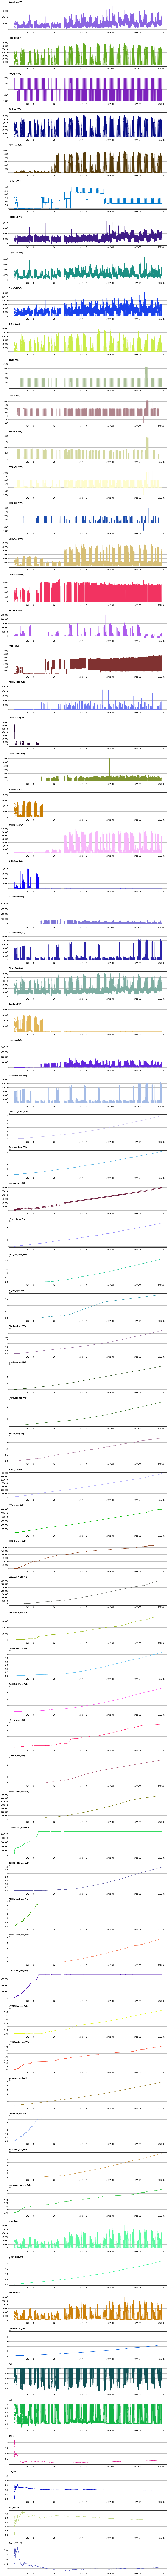

In [42]:
fig, ax = plt.subplots(figsize=(18,300))

for i in range(len(df_kpec.columns)):
    plt.subplot(len(df_kpec.columns), 1, i+1)
    plt.subplots_adjust(hspace=0.4)
    name = df_kpec.columns[i]
    r=random.random()
    g=random.random()
    b=random.random()
    color=(r,g,b)
    plt.plot(df_kpec[name], color=color)    
    plt.title(name, loc = 'left', pad=15, fontsize=13, fontweight="bold")      
    plt.yticks(fontsize=13)    
    plt.xticks(fontsize=13)                
    plt.xlim(pd.Timestamp('2021-09-07'), pd.Timestamp('2022-03-07'))    
    plt.grid(True)
plt.show()
fig.tight_layout()

# 주거용 건물

## KePSH1

In [ ]:
data = pd.read_csv('./data/220114/220114 kepsh1.csv', parse_dates = True)

In [ ]:
all_features = data.columns.tolist()
print(all_features)

In [ ]:
df_kepsh1 = pd.DataFrame()
df_kepsh1['Time'] = data['DateTime']
df_kepsh1['PV_kepsh1(W)'] = np.where(data['Pv_Supply(W)']<0, 0, data['Pv_Supply(W)'])
df_kepsh1['PVT_kepsh1(W)'] = np.where(data['Pvt_Supply(W)']<0, 0, data['Pvt_Supply(W)'])
df_kepsh1['FC(W)'] = data['FuelCell_Supply(W)']
df_kepsh1['HP_kepsh1(W)'] = data['Heatpump_Load(W)']
df_kepsh1['Cons_kepsh1(W)'] = data['Total_Consumption(W)']
df_kepsh1['Prod_kepsh1(W)'] = data['Total_Production(W)']
df_kepsh1['ESS(W)'] = data['ESS_Power(W)']*(-1)

df_kepsh1.head()


In [ ]:
df_kepsh1['Time'] = pd.to_datetime(df_kepsh1['Time'])

In [ ]:
df_kepsh1 = df_kepsh1[(df_kepsh1['Time']>='2021-09-13 00:00:00') ]
df_kepsh1 = df_kepsh1[(df_kepsh1['Time']<='2021-12-31 23:59:00') ]

In [ ]:
df_kepsh1 = df_kepsh1.set_index('Time')

In [ ]:
df_kepsh1.info()

In [ ]:
df_kepsh1['Cons_kepsh1(W)'] = df_kepsh1['Cons_kepsh1(W)'].astype(float)
df_kepsh1['Prod_kepsh1(W)'] = df_kepsh1['Prod_kepsh1(W)'].astype(float)

In [ ]:
df_kepsh1['Cons_acc_kepsh1(Wh)'] = df_kepsh1['Cons_kepsh1(W)'].cumsum()*60/3600
df_kepsh1['Prod_acc_kepsh1(Wh)'] = df_kepsh1['Prod_kepsh1(W)'].cumsum()*60/3600

In [ ]:
df_kepsh1['PV_acc_kepsh1(Wh)'] = df_kepsh1['PV_kepsh1(W)'].cumsum()*60/3600
df_kepsh1['PVT_acc_kepsh1(Wh)'] = df_kepsh1['PVT_kepsh1(W)'].cumsum()*60/3600
df_kepsh1['FC_acc(Wh)'] = df_kepsh1['FC(W)'].cumsum()*60/3600

In [ ]:
df_kepsh1['denominator'] = df_kepsh1.loc[:,['Cons_kepsh1(W)','Prod_kepsh1(W)']].min(axis=1)
df_kepsh1['denominator_acc'] = df_kepsh1.loc[:,['Cons_acc_kepsh1(Wh)','Prod_acc_kepsh1(Wh)']].min(axis=1)

In [ ]:
df_kepsh1['SCF'] = df_kepsh1['denominator']/df_kepsh1['Prod_kepsh1(W)']
df_kepsh1['LCF'] = df_kepsh1['denominator']/df_kepsh1['Cons_kepsh1(W)']

In [ ]:
df_kepsh1['SCF_acc'] = df_kepsh1['denominator_acc']/df_kepsh1['Prod_acc_kepsh1(Wh)']
df_kepsh1['LCF_acc'] = df_kepsh1['denominator_acc']/df_kepsh1['Cons_acc_kepsh1(Wh)']
df_kepsh1['self_sustain'] = df_kepsh1['Prod_acc_kepsh1(Wh)']/df_kepsh1['Cons_acc_kepsh1(Wh)']
df_kepsh1['Avg_SCF&LCF'] = (df_kepsh1['SCF_acc']+df_kepsh1['LCF_acc'])/2

In [ ]:
df_kepsh1

In [ ]:
df_kepsh1.to_csv('./data/220114_kepsh1.csv')

In [ ]:
fig, ax = plt.subplots(figsize=(18,70))

for i in range(len(df_kepsh1.columns)):
    plt.subplot(len(df_kepsh1.columns), 1, i+1)
    plt.subplots_adjust(hspace=0.5)
    name = df_kepsh1.columns[i]
    r=random.random()
    g=random.random()
    b=random.random()
    color=(r,g,b)
    plt.plot(df_kepsh1[name], color=color)    
    plt.title(name, loc = 'left', pad=15, fontsize=13, fontweight="bold")      
    plt.yticks(fontsize=13)    
    plt.xticks(fontsize=13)                
    plt.xlim(pd.Timestamp('2021-09-07'), pd.Timestamp('2022-01-07'))    
    plt.grid(True)
plt.show()
fig.tight_layout()

## KePSH2

In [ ]:
data = pd.read_csv('./data/220114/220114 kepsh2.csv', parse_dates = True)

In [ ]:
data

In [ ]:
df_kepsh2 = pd.DataFrame()
df_kepsh2['Time'] = data['DateTime']
# PV, PVT 음수값은 0으로 처리
df_kepsh2['PV_kepsh2(W)'] = np.where(data['BIPV_Supply(W)']<0, 0, data['BIPV_Supply(W)'])
df_kepsh2['PVT_kepsh2(W)'] = np.where(data['Pvt_Supply(W)']<0, 0, data['Pvt_Supply(W)'])
df_kepsh2['Cons_kepsh2(W)'] = data['Total_Consumption(W)']
df_kepsh2['Prod_kepsh2(W)'] = data['Total_Production(W)']

df_kepsh2.head()


In [ ]:
df_kepsh2['Time'] = pd.to_datetime(df_kepsh2['Time'])

In [ ]:
df_kepsh2 = df_kepsh2[(df_kepsh2['Time']>='2021-09-13 00:00:00') ]
df_kepsh2 = df_kepsh2[(df_kepsh2['Time']<='2021-12-31 23:59:00') ]

In [ ]:
df_kepsh2['Cons_kepsh2(W)'] = df_kepsh2['Cons_kepsh2(W)'].astype(float)
df_kepsh2['Prod_kepsh2(W)'] = df_kepsh2['Prod_kepsh2(W)'].astype(float)

In [ ]:
df_kepsh2 = df_kepsh2.set_index('Time')

In [ ]:
df_kepsh2['Cons_acc_kepsh2(Wh)'] = df_kepsh2['Cons_kepsh2(W)'].cumsum()*60/3600
df_kepsh2['Prod_acc_kepsh2(Wh)'] = df_kepsh2['Prod_kepsh2(W)'].cumsum()*60/3600

In [ ]:
df_kepsh2['PV_acc_kepsh2(Wh)'] = df_kepsh2['PV_kepsh2(W)'].cumsum()*60/3600
df_kepsh2['PVT_acc_kepsh2(Wh)'] = df_kepsh2['PVT_kepsh2(W)'].cumsum()*60/3600

In [ ]:
df_kepsh2['denominator'] = df_kepsh2.loc[:,['Cons_kepsh2(W)','Prod_kepsh2(W)']].min(axis=1)
df_kepsh2['denominator_acc'] = df_kepsh2.loc[:,['Cons_acc_kepsh2(Wh)','Prod_acc_kepsh2(Wh)']].min(axis=1)

In [ ]:
df_kepsh2['SCF'] = df_kepsh2['denominator']/df_kepsh2['Prod_kepsh2(W)']
df_kepsh2['LCF'] = df_kepsh2['denominator']/df_kepsh2['Cons_kepsh2(W)']

In [ ]:
df_kepsh2['SCF_acc'] = df_kepsh2['denominator_acc']/df_kepsh2['Prod_acc_kepsh2(Wh)']
df_kepsh2['LCF_acc'] = df_kepsh2['denominator_acc']/df_kepsh2['Cons_acc_kepsh2(Wh)']
df_kepsh2['self_sustain'] = df_kepsh2['Prod_acc_kepsh2(Wh)']/df_kepsh2['Cons_acc_kepsh2(Wh)']
df_kepsh2['Avg_SCF&LCF'] = (df_kepsh2['SCF_acc']+df_kepsh2['LCF_acc'])/2

In [ ]:
df_kepsh2.info()

In [ ]:
df_kepsh2

In [ ]:
fig, ax = plt.subplots(figsize=(18,60))

for i in range(len(df_kepsh2.columns)):
    plt.subplot(len(df_kepsh2.columns), 1, i+1)
    plt.subplots_adjust(hspace=0.5)
    name = df_kepsh2.columns[i]
    r=random.random()
    g=random.random()
    b=random.random()
    color=(r,g,b)
    plt.plot(df_kepsh2[name], color=color)    
    plt.title(name, loc = 'left', pad=15, fontsize=13, fontweight="bold")      
    plt.yticks(fontsize=13)    
    plt.xticks(fontsize=13)                
    plt.xlim(pd.Timestamp('2021-09-07'), pd.Timestamp('2022-01-07'))    
    plt.grid(True)
plt.show()
fig.tight_layout()